In [1]:
import torch as t
import torch.nn as nn 
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset,DataLoader,Dataset
import sklearn.model_selection as pp
import cv2
import os 


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np


In [2]:
data = np.load("/Users/bhara-zstch1566/CNN/Eval/dataset_preprocessed.npz")
X, Y = data['X'], data['Y']


In [3]:
print(set((Y)))

{np.int32(0), np.int32(1), np.int32(2)}


In [4]:
print(f"Total images loaded: {len(X)}")
print(f"Unique labels: {set(Y)}")
seen = set()
for i in range(len(X)):
    seen.add(X[i].shape)
seen

Total images loaded: 32077
Unique labels: {np.int32(0), np.int32(1), np.int32(2)}


{(128, 128, 3)}

In [5]:
for i in range(len(X)):
    if X[i] is None:
        print(f"❌ Image at index {i} is None for label {Y[i]}")


In [6]:
X[0].shape

(128, 128, 3)

In [7]:
import torch
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

# Apply to all images
X_tensors = [transform(img) for img in X]       # list of tensors (3,128,128)
X = torch.stack(X_tensors)             # shape: (32077, 3, 128, 128)
Y = torch.tensor(Y)                    # shape: (32077,)


In [8]:
X.shape

torch.Size([32077, 1, 128, 128])

In [9]:
Y.shape

torch.Size([32077])

In [10]:
x_train,x_test,y_train,y_test = pp.train_test_split(X,Y,test_size=0.15,random_state=42,shuffle=True)

In [11]:
train_loader = TensorDataset(x_train,y_train)
train_loader = DataLoader(train_loader,64,True)

test_loader = TensorDataset(x_test,y_test)
test_loader = DataLoader(test_loader,64,True)

In [12]:
x_test.shape

torch.Size([4812, 1, 128, 128])

In [13]:
class Alexnet(nn.Module):
    def __init__(self):
        super(Alexnet,self).__init__()
        self.Convlayer = nn.Sequential(
            nn.Conv2d(1,64,11,stride=2,padding=4),
            nn.ReLU(),
            nn.MaxPool2d(2,2),       
            nn.Conv2d(64,128,5,stride=1,padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(128,256,3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(256,512,5,stride=2,padding=2)
        )

        self.net = nn.Sequential(
            nn.Linear(512*4*4,4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096,4096),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(4096,3)
        )
    def forward(self,x):
        x = self.Convlayer(x)
        x = x.view(x.size(0), -1)
        x = self.net(x)
        return x


In [14]:
model = Alexnet()
device = 'mps' if t.mps.is_available() else "cpu"
model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(),lr=0.001)
all_preds =[]
all_labels = []


In [15]:
model.Convlayer(t.rand(1,1,128,128).to(device)).shape

torch.Size([1, 512, 4, 4])

In [16]:
for i in range(5):
    running_loss = 0.0

    for img,label in train_loader:
        img,label =img.to(device),label.to(device)
        y_pred = model(img)
        loss = criterion(y_pred,label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    with t.no_grad():
        ttotal =0
        tcet = 0
        for img,label in test_loader:
            img ,label = img.to(device),label.to(device)
            y_pred = model(img)
            _,predicted = t.max(y_pred.data, 1)
            ttotal += label.size(0)
            tcet += (predicted == label).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    
    print(f"Epoch [{i+1}/{5}], Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100*tcet/ttotal:.2f}%")


Epoch [1/5], Loss: 0.6629, Accuracy: 70.05%
Epoch [2/5], Loss: 0.4575, Accuracy: 85.68%
Epoch [3/5], Loss: 0.3679, Accuracy: 85.06%
Epoch [4/5], Loss: 0.3445, Accuracy: 84.43%
Epoch [5/5], Loss: 0.2986, Accuracy: 84.77%


In [17]:
# from torchvision import models

# # Load pretrained MobileNetV2
# model = models.mobilenet_v2(pretrained=True)

# # Replace classifier
# model.classifier[1] = nn.Linear(model.last_channel, 3)
# model = model.to(device)

# # Freeze backbone if needed
# for param in model.features.parameters():
#     param.requires_grad = False

# # Train only classifier first


In [18]:
t.save(model.state_dict(), "model1.pth")

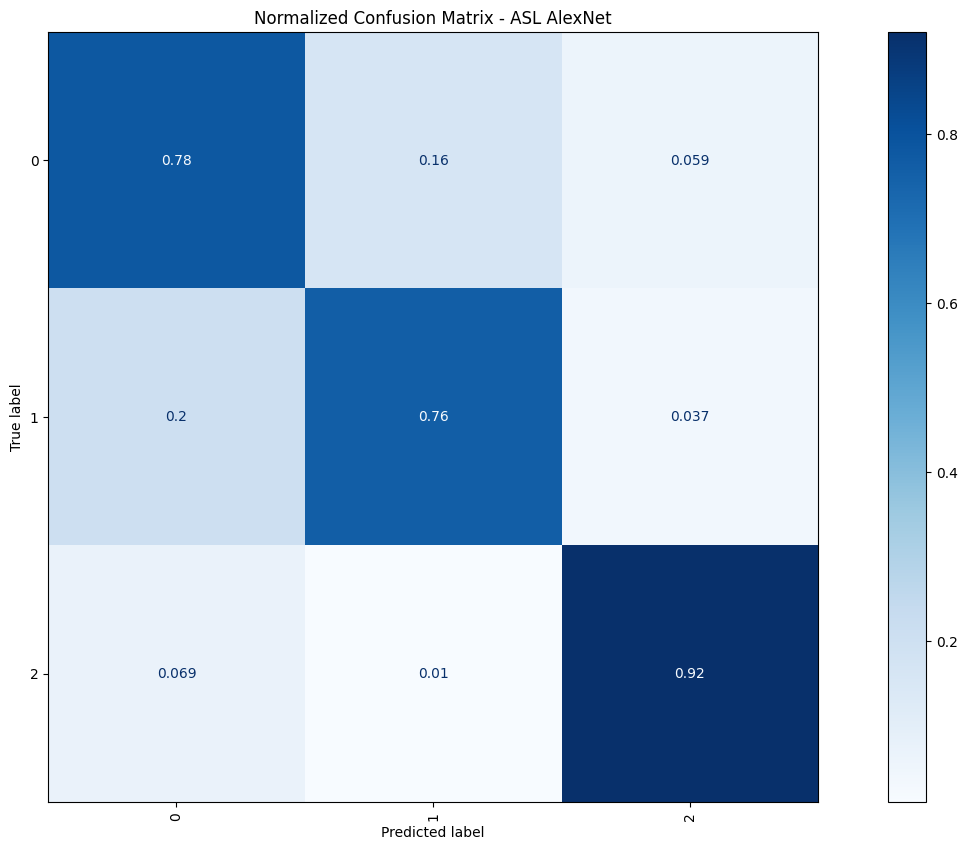

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

labels = np.unique(all_labels)  
cm = confusion_matrix(all_labels, all_preds, labels=labels)


cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(18, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)
disp.plot(cmap='Blues', ax=ax, xticks_rotation=90)
plt.title("Normalized Confusion Matrix - ASL AlexNet")
plt.show()


In [ ]:
import cv2
import torch
import torch as t
cap = cv2.VideoCapture(0)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
class_lab = ['water bottle', 'Mobile', 'Nothing']
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = Alexnet()
model.load_state_dict(torch.load("/Users/bhara-zstch1566/CNN/Eval/Model/Model/model1.pth", map_location=device))
model.to(device)
model.eval()

model.eval()
while True:
    ret, frame = cap.read()
    if not ret:
        break

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = transform(img).unsqueeze(0).to(device)

    with t.no_grad():
        outputs = model(img)
        _, pred = t.max(outputs,1)
    label_text = class_lab[pred.item()]

    cv2.putText(frame, label_text, (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
    cv2.imshow("Live Prediction", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


: 

In [21]:
# import cv2 as cv
# import torch
# import torch.nn as nn
# import torchvision.transforms as transforms
# import numpy as np

# # ---------- 1️⃣ Load your trained model ----------
# # 1️⃣ Define the model architecture exactly like during training
# model = Alexnet()  

# # 2️⃣ Load weights (state_dict)
# device = torch.device("mps" if torch.mps.is_available() else "cpu")
# state_dict = torch.load("/Users/bhara-zstch1566/CNN/Eval/Model/model1.pth", map_location=device)
# model.load_state_dict(state_dict)

# # 3️⃣ Move to device and set eval mode
# model.to(device)
# model.eval()

# # ---------- 2️⃣ Define preprocessing ----------
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.Resize((128, 128)),   # match your training size
#     transforms.ToTensor()
# ])

# classes = ["water_can", "mobile", "nothing"]  # adjust if different

# # ---------- 3️⃣ Start camera ----------
# cap = cv.VideoCapture(0)

# print("✅ Live detection started — press 'q' to quit")

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break

#     # ---------- 4️⃣ Preprocess for motion-based object cropping ----------
#     gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
#     blur = cv.GaussianBlur(gray, (5, 5), 0)
#     _, thresh = cv.threshold(blur, 40, 255, cv.THRESH_BINARY_INV + cv.THRESH_OTSU)
#     contours, _ = cv.findContours(thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

#     detections = []

#     for c in contours:
#         x, y, w, h = cv.boundingRect(c)
#         if w * h > 5000:  # filter out tiny noise
#             roi = frame[y:y+h, x:x+w]

#             # ---------- 5️⃣ Transform ROI and predict ----------
#             try:
#                 img_tensor = transform(roi).unsqueeze(0).to(device)
#                 with torch.no_grad():
#                     outputs = model(img_tensor)
#                     _, predicted = torch.max(outputs.data, 1)
#                     label = classes[predicted.item()]
#                     detections.append((x, y, w, h, label))
#             except Exception as e:
#                 # skip bad crop sizes
#                 continue

#     # ---------- 6️⃣ Draw results ----------
#     for (x, y, w, h, label) in detections:
#         cv.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
#         cv.putText(frame, label, (x, y-10), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2)

#     cv.imshow("Live Detection", frame)

#     if cv.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv.destroyAllWindows()
